# Data Analysis and Prediction on Wine dataset

Imports and helper functions
---

In [1]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn import neighbors
from sklearn import pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

## Data Cleaning

In [2]:
# read in the csv files and transform them into pandas data frames 
df_red = pd.read_csv("./raw_data/winequality-red.csv", na_values=[''])
df_white = pd.read_csv("./raw_data/winequality-white.csv", na_values=[''])

In [3]:
# fill in the null values in the dataframe with 0
df_red.fillna(0, inplace=True)
df_white.fillna(0, inplace=True)

## Visualize raw data with d3.js/dc.js/crossfilter.js library

### Prepare data

In [4]:
# combine the red wine and white wine data into the same data frame
frames = [df_red, df_white]
df_whole = pd.concat(frames, keys=['red', 'white'])

# change the name and data type for label 'red' and 'white' 
df_whole.reset_index(level=0, inplace=True)
df_whole["level_0"] = df_whole["level_0"].astype('category')
df_whole.rename(columns={'level_0': 'Type'}, inplace=True)

# write the clean combined data frame into a csv file for visualization
df_whole.to_csv("./visualization/clean_data/data_wine.csv", index=False)

# the metadata information for this data set
metadata = {'number of category data': 2, 
            'category': ['Type', 'quality'],
            'number of numerical data': 11, 
            'numerical': ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
                          'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 
                          'pH', 'sulphates', 'alcohol']}

# write the metadata into a json file for visualization
with open('./visualization/clean_data/metadata_wine.json', 'w') as writer:
    json.dump(metadata, writer)

### visualize data
Go to the following website and click on the "Wine" button to see the visualizations.
http://www-edlab.cs.umass.edu/~yuanh/590v/hw2/index.html

## Data Analysis

In [5]:
data_red = df_red.iloc[:,:].values
features_name = list(df_red.columns.values)

#Load Red Wine Data
x = data_red[:,:-1]
y = data_red[:,-1]
n_features = x.shape[1]

print "red wine data size: ", data_red.shape
print "feature names: ", features_name

red wine data size:  (1599, 12)
feature names:  ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


### Correlation Matrix

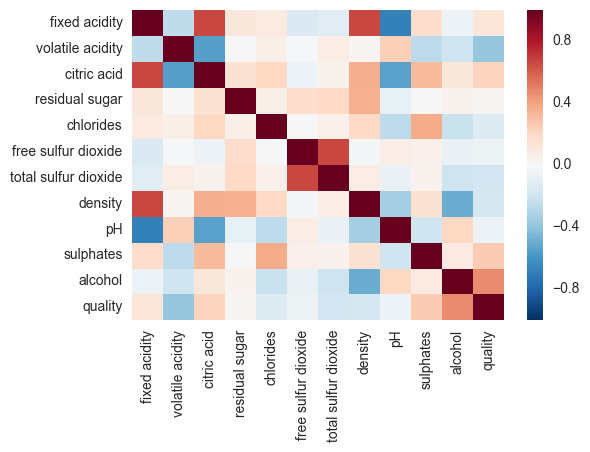

In [6]:
# plot the correlation matrix heatmap for red wine data
corr_red = df_red.corr()
sns.heatmap(corr_red, xticklabels=corr_red.columns.values, yticklabels=corr_red.columns.values)

### Principal Component Analysis

explained variance ratio : 
 [  9.46576976e-01   4.83683046e-02   2.58917183e-03   1.51896798e-03
   8.73553990e-04   3.45607218e-05   1.93627614e-05   9.47278079e-06
   8.41376628e-06   1.21472798e-06   4.68762788e-10]
Feature ranking in pca:
 1. feature  6: total sulfur dioxide (0.975678)
 2. feature  5:  free sulfur dioxide (0.218857)
 3. feature  3:       residual sugar (0.008649)
 4. feature  1:     volatile acidity (0.000384)
 5. feature  9:            sulphates (0.000223)
 6. feature  2:          citric acid (0.000171)
 7. feature  4:            chlorides (0.000064)
 8. feature  7:              density (0.000004)
 9. feature  8:                   pH (-0.000268)
10. feature  0:        fixed acidity (-0.006132)
11. feature 10:              alcohol (-0.006358)


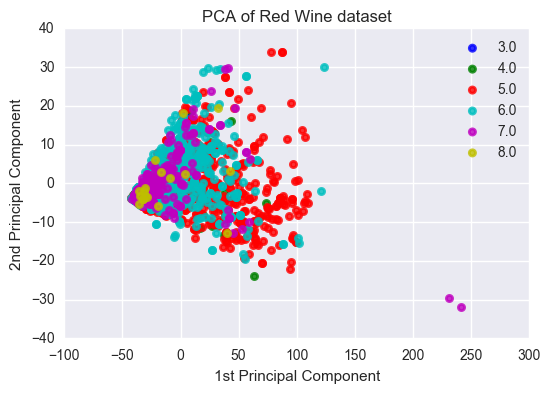

In [7]:
pca = PCA()
x_pca = pca.fit(x).transform(x)

# Percentage of variance explained for each components
print('explained variance ratio : \n %s'
      % str(pca.explained_variance_ratio_))

indices = np.argsort(pca.components_[0])[::-1]

# Print the feature ranking
print("Feature ranking in pca:")

# Percentage of features explained for each components
for f in range(n_features):
    print("%2d. feature %2d: %20s (%f)" % (f+1, indices[f], features_name[indices[f]], pca.components_[0][indices[f]]))

plt.figure()
colors = 'bgrcmyk'
lw = 2

for color, i in zip(colors, set(y)):
    plt.scatter(x_pca[y == i, 0], x_pca[y == i, 1], color=color, alpha=.8, lw=lw,
                label=str(i))
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Red Wine dataset')
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.show()

### Red Wine Quality Prediction

### Model Selection

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
models = ["regression tree", "random forest", "support vector machine"]
R2_scores = {}

#### 1. Regression Tree

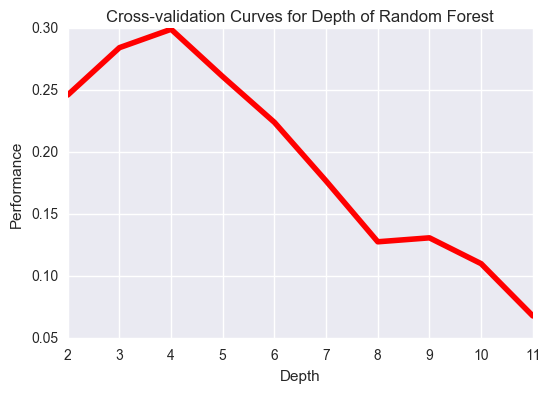

In [9]:
#Set max depth for trees
max_depth=12

#Set depths to evaluate
depths = np.arange(2,max_depth)
scores = np.zeros(len(depths))

#Learn an evaluate trees of different depths
for i in range(len(depths)):

    #Learn the classifer
    clf = DecisionTreeRegressor(max_depth=depths[i]) 
                                      
    #Compute train and test errors                                  
    scores[i] = cross_val_score(clf, x_train, y_train, cv=5).mean()

R2_scores["regression tree"] = scores.max()

#Plot the results
plt.figure(1)
plt.plot(depths, scores[:], 'r-', linewidth=4)
plt.grid(True)
plt.xlabel("Depth")
plt.ylabel("Performance")
plt.title("Cross-validation Curves for Depth of Random Forest")

#### 2. Random Forest

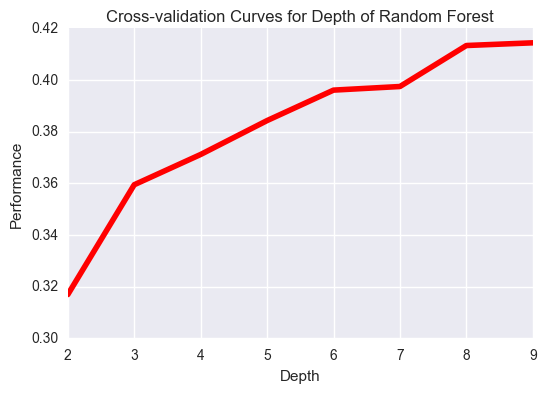

In [10]:
# Parameters for Random Forest
n_estimators = 30
max_depth = 10

#Set depths to evaluate
depths = np.arange(2,max_depth)
scores = np.zeros(len(depths))

#Learn a random forest of different depths
for i in range(len(depths)):

    #Learn the classifer
    clf = RandomForestRegressor(n_estimators=n_estimators, max_depth=depths[i], random_state=42) 
                                      
    #Compute train and test errors                                  
    scores[i] = cross_val_score(clf, x_train, y_train, cv=5).mean()
    
R2_scores["random forest"] = scores.max()

#Plot the results
plt.figure(1)
plt.plot(depths, scores[:], 'r-', linewidth=4)
plt.grid(True)
plt.xlabel("Depth")
plt.ylabel("Performance")
plt.title("Cross-validation Curves for Depth of Random Forest")

#### 3. Support Vector Machine

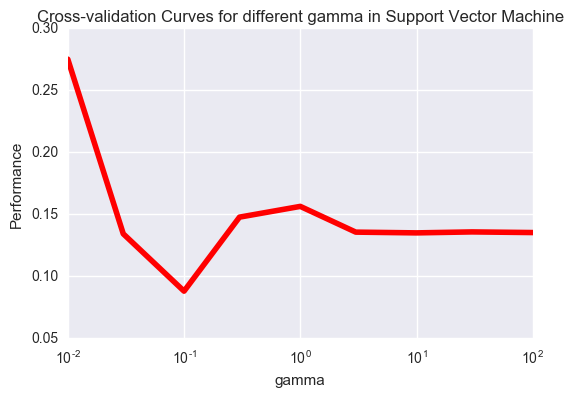

In [11]:
# Parameters for Support Vector Regressor
gamma_list = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]
scores = np.zeros(len(gamma_list))

for i in range(len(gamma_list)):
    clf = SVR(C=10.0, gamma=gamma_list[i])

    #Compute train and test errors                                  
    scores[i] = cross_val_score(clf, x_train, y_train, cv=5).mean()
    
R2_scores["support vector machine"] = scores.max()
    
#Plot the results
plt.figure(1)
plt.plot(gamma_list, scores[:], 'r-', linewidth=4)
plt.grid(True)
plt.xscale('log')
plt.xlabel("gamma")
plt.ylabel("Performance")
plt.title("Cross-validation Curves for different gamma in Support Vector Machine")

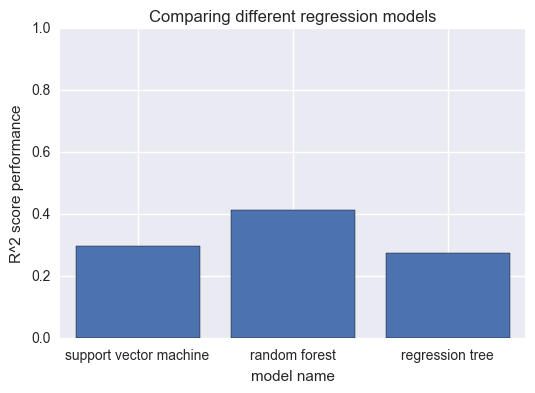

In [12]:
plt.figure()
bar_offset = 0.1
plt.bar([i+bar_offset for i in range(len(models))], [R2_scores[model] for model in models])
plt.title("Comparing different regression models")
plt.xlabel('model name')
tick_offset = 0.5
plt.xticks([i+tick_offset for i in range(len(models))], R2_scores.keys())
plt.ylabel('R^2 score performance')
plt.ylim((0, 1))
plt.show()

### Wine Quality Prediction with Random Forest with Max Depth 8

In [13]:
random_forest = RandomForestRegressor(max_depth=8, random_state=42) 

In [14]:
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [15]:
y_pred = random_forest.predict(x_test)

In [16]:
random_forest.score(x_test, y_test)

0.39551235378352767

In [17]:
def get_pred_quality_level(pred_quality_float, true_quality_int, tolerance):
    pred_quality_int = np.zeros(len(true_quality_int))
    for i in range(len(true_quality_int)):
        if abs(pred_quality_float[i]-true_quality_int[i]) <= tolerance:
            pred_quality_int[i] = true_quality_int[i]
        else:
            pred_quality_int[i] = round(pred_quality_float[i])
    return pred_quality_int

def accuracy(pred_quality, true_quality):
    return np.sum(true_quality==pred_quality)*1.0/len(true_quality)

In [18]:
# Predict the quality class for the test data with tolerance range +-1.0
pred_quality = get_pred_quality_level(y_pred, y_test, tolerance=1.0)

# Accuracy
print "Accuracy with tolerance 1.0: ", accuracy(pred_quality, y_test)

Accuracy with tolerance 1.0:  0.914583333333


[[  0   0   1   0   0   0]
 [  0   1  11   5   0   0]
 [  0   0 190   4   1   0]
 [  0   0   1 198   1   0]
 [  0   0   2  10  49   0]
 [  0   0   0   3   2   1]]


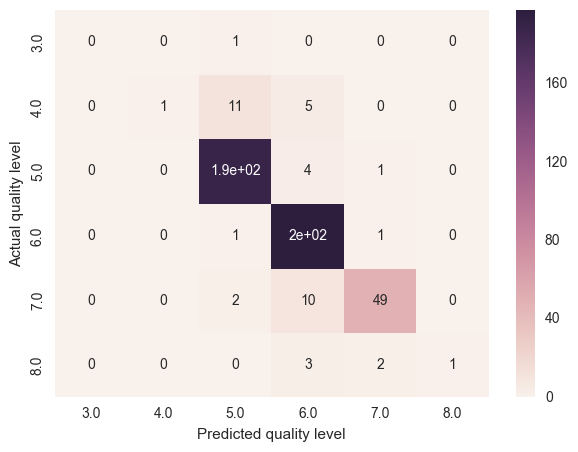

In [19]:
# Confusion Matrix for the predicitons on the test data
conf_mat = confusion_matrix(y_test, pred_quality)
print conf_mat
df_cm = pd.DataFrame(conf_mat, index = [str(i) for i in set(y_test)],
                  columns = [i for i in set(y_test)])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
plt.xlabel("Predicted quality level")
plt.ylabel("Actual quality level")

Feature ranking in random forest:
 1. feature 10:              alcohol (0.341021)
 2. feature  9:            sulphates (0.164836)
 3. feature  1:     volatile acidity (0.119144)
 4. feature  4:            chlorides (0.064914)
 5. feature  6: total sulfur dioxide (0.062213)
 6. feature  3:       residual sugar (0.051152)
 7. feature  8:                   pH (0.049288)
 8. feature  0:        fixed acidity (0.041474)
 9. feature  2:          citric acid (0.040029)
10. feature  5:  free sulfur dioxide (0.036844)
11. feature  7:              density (0.029084)


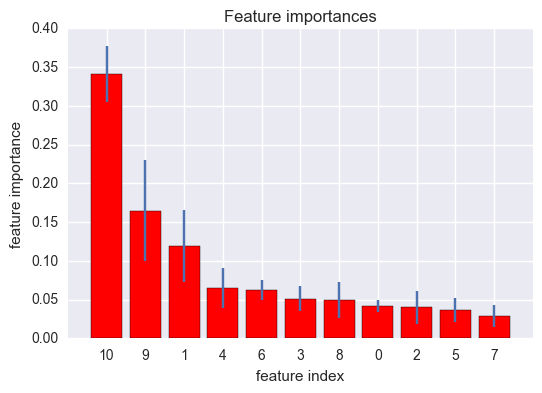

In [20]:
# Feature Importances of the random forest
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking in random forest:")


for f in range(n_features):
    print("%2d. feature %2d: %20s (%f)" % (f + 1, indices[f], features_name[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(n_features), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(n_features), indices)
plt.xlabel('feature index')
plt.ylabel('feature importance')
plt.xlim([-1, n_features])
plt.show()